In [1]:
from utils import *
from data_processing import *
today = datetime.date.today()

In [2]:
config = TsConf()
df = TsDataFrame(pd.read_csv(config.cmapss_url))
df.columns = config.columns_old
df = df[config.columns_new]

In [3]:
df = df.cluster(config)

In [4]:
df = df.data_norm(config)

In [5]:
config.ewm = 20
df = df.ewma(config)

In [6]:
train = df[(["FILEID","ENGINEID", "TIMECYCLE"]+config.select_feat+["RUL"])][df.FILEID.isin(config.train_fids)]
test = df[(["FILEID","ENGINEID", "TIMECYCLE"]+config.select_feat+["RUL"])][df.FILEID.isin(config.test_fids)]

In [7]:
train.tail()

,FILEID,ENGINEID,TIMECYCLE,Total temp at LPC out (T24),Total temp at HPC out (T30),Total temp at LPT out (T50),Physical core speed (Nc),Static pres at HPC out (Ps30),Corrected core speed (NRc),Bypass Ratio (BPR),Bleed Enthalpy (htBleed),RUL
87480,102,260,312,1.181564,1.400266,1.404234,4.871879,1.204583,4.903128,1.136318,1.453609,4
87481,102,260,313,1.215280,1.434809,1.409812,4.980184,1.258923,4.997293,1.199401,1.521893,3
87482,102,260,314,1.239175,1.488724,1.395823,5.076812,1.276316,5.098160,1.309503,1.547101,2
87483,102,260,315,1.309800,1.510402,1.441107,5.163097,1.333994,5.198679,1.401138,1.607943,1
87484,102,260,316,1.338534,1.505439,1.462482,5.260137,1.377636,5.300208,1.418648,1.659060,0


# Model training

## LSTM (Sibur)

In [8]:
n_eng_train = max(train.ENGINEID)
n_eng_test = max(test.ENGINEID)

In [9]:
train.target = config.target
train.groupids = config.groupids
train.timestamp = config.timestamp
test.target = config.target
test.groupids = config.groupids
test.timestamp = config.timestamp

In [10]:
Train = False
Predict = not Train

In [11]:
config.sequence_length = 1
config.batch_size = 1
config.shift = 1
config.restore_model = True
config.save_model = True
config.random = False
config.stateful = True

In [12]:
config.display()


Configurations:
alpha                          0
ann_hidden                     16
batch_size                     1
cmapss_n_clusters              6
cmapss_url                     input/dataset.csv
columns_new                    ['FILEID', 'ENGINEID', 'TIMECYCLE', 'Alt', 'Mach', 'TRA', 'Total temp at fan in (T2)', 'Total temp at LPC out (T24)', 'Total temp at HPC out (T30)', 'Total temp at LPT out (T50)', 'Pres at fan in (P2)', 'Total pres in bypass-duct (P15)', 'Total pres at HPC out (P30)', 'Physical fan speed (Nf)', 'Physical core speed (Nc)', 'Engine pres ratio (epr=P50/P2)', 'Static pres at HPC out (Ps30)', 'Ratio of fuel flow to Ps30 (phi)', 'Corrected fan speed (NRf)', 'Corrected core speed (NRc)', 'Bypass Ratio (BPR)', 'Burner fuel-air ratio (farB)', 'Bleed Enthalpy (htBleed)', 'Demanded fan speed (Nf_dmd)', 'Demanded corrected fan speed (PCNfR_dmd)', 'HPT coolant bleed (W31)', 'LPT coolant bleed (W32)', 'RUL']
columns_old                    ['ENGINEID', 'TIMECYCLE', 'Alt', 'M

In [13]:
m = TsLSTM(config)

Building LSTM...
My Conv Shape: [None, 1, 8]


In [14]:
if Train:
    m.train(train, test, config)

INFO:tensorflow:Restoring parameters from ./save/new_lstm/cha_8_len_1_bat_1/lstm_2_layers_stateful_True
Model restored from file: ./save/new_lstm/cha_8_len_1_bat_1/lstm_2_layers_stateful_True
Prediction for submit...
#of validation points: 164 #datapoints covers from minibatch: 1
name: (202, 13), n: 164, start: 0, finish: 164, Samples length: 164 , Targets length 164: 


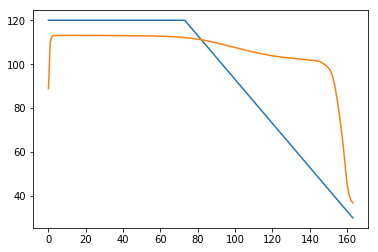

In [26]:
if Predict:
    dtrain = test.loc[test.ENGINEID==13]
    y_target = dtrain["RUL"]
    y_pred = m.predict(dtrain, config)
    z=pd.DataFrame(dict(target=y_target, pred=y_pred)).reset_index()
    plt.plot(z[["target", "pred"]])

In [16]:
#pd.DataFrame(out)

In [17]:
#y_submit = full_prediction*std_y+mean_y
#sub_file = pd.DataFrame()
#sub_file["timestamp"] = submit_X.index[-2872:]
#sub_file["target"] = y_submit[-2872:]
#sub_file.to_csv('submit2.csv', index=False)

## Gradient Boosting Regression

### TS fresh dataset

In [18]:
#add_lag_roll(test.iloc[:,:-2], feat_names, lag=lag, step=step, roll=0).head()

In [19]:
#df.groupby(["FILEID", "ENGINEID"])

In [20]:
#X=pd.DataFrame()
#y=list()

In [21]:
#for name, group in df.groupby(["FILEID", "ENGINEID"]):
    #X = pd.concat([X, add_lag_roll(group[feat_names], feat_names, lag=lag, step=step)], axis=0)
    #y = y.append(group["RUL"][lag:])
    
    

In [22]:
#X.tail(1).values